# Model Agnostic w LIME (PyTorch)

## What is LIME?

LIME is a support package which provides model agnostic features for any machine learning/deep learning models.

In [ ]:
!pip install torchinfo
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import misc libraries
import numpy as np
import matplotlib.pyplot as plt
import lime
import glob
import os
from PIL import Image
import json
from skimage.segmentation import mark_boundaries

# import torch modules
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from torchinfo import summary

print('torch:', torch.__version__)
print('torchvision:', torchvision.__version__)

torch: 1.12.0+cu113
torchvision: 0.13.0+cu113


## Mount GDrive Volume

At the current moment, the data is migrated to my Google Drive (Yu Hoe). Requires to mount to my drive volume in order to access the image dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Pre-trained ResNet18 on Pneumonia Classification

In [ ]:
# reproducible code to intialise model
def load_model(model='mobilenetv3', weights_path: str = '/content/drive/MyDrive/Pneumonia Classification/mobilenetv3_ver2_best_weights.pth'):  
    """
    It loads a pre-trained model and returns it
    
    :param model: The model to be used, defaults to mobilenetv3 (optional)
    :param weights_path: str = 'assets/weights/mobilenetv3_best_weights.pth', defaults to
    assets/weights/mobilenetv3_best_weights.pth
    :type weights_path: str (optional)
    :return: The model is being returned.
    """
    if model == 'resnet18':
        model_ft = models.resnet18()
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 2)
        model_ft.load_state_dict(torch.load(weights_path))
        return model_ft
    
    elif model == 'efficientnetb1':
        model_ft = models.efficientnet_b1()
        num_ftrs = model_ft.classifier[-1].in_features
        # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
        model_ft.classifier[-1] = nn.Linear(num_ftrs, 2)
        model_ft.load_state_dict(torch.load(weights_path))
        return model_ft
    
    elif model == 'mobilenetv3':
        model_ft = models.mobilenet_v3_large()
        num_ftrs = model_ft.classifier[-1].in_features
        # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
        model_ft.classifier[-1] = nn.Linear(num_ftrs, 2)
        model_ft.load_state_dict(torch.load(weights_path))
        return model_ft

# load ResNet18 model
PATH = 'drive/MyDrive/Pneumonia Classification/best_weights.pth'
model = load_model() 
summary(model, [1, 3, 224, 224], depth=2)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 2]                    --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           3,440
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           4,440
│    └─InvertedResidual: 2-5                       [1, 40, 28, 28]           10,328
│    └─InvertedResidual: 2-6                       [1, 40, 28, 28]           20,992
│    └─InvertedResidual: 2-7                       [1, 40, 28, 28]           20,992
│    └─InvertedResidual: 2-8                       [1, 80, 14, 14]           32,080
│    └─InvertedResidual: 2-9                       [1, 80, 14, 14]           34,760
│    └─

## Prepare Test Images

drive/MyDrive/Pneumonia Classification/chest_xray/test/PNEUMONIA/person1951_bacteria_4882.jpeg


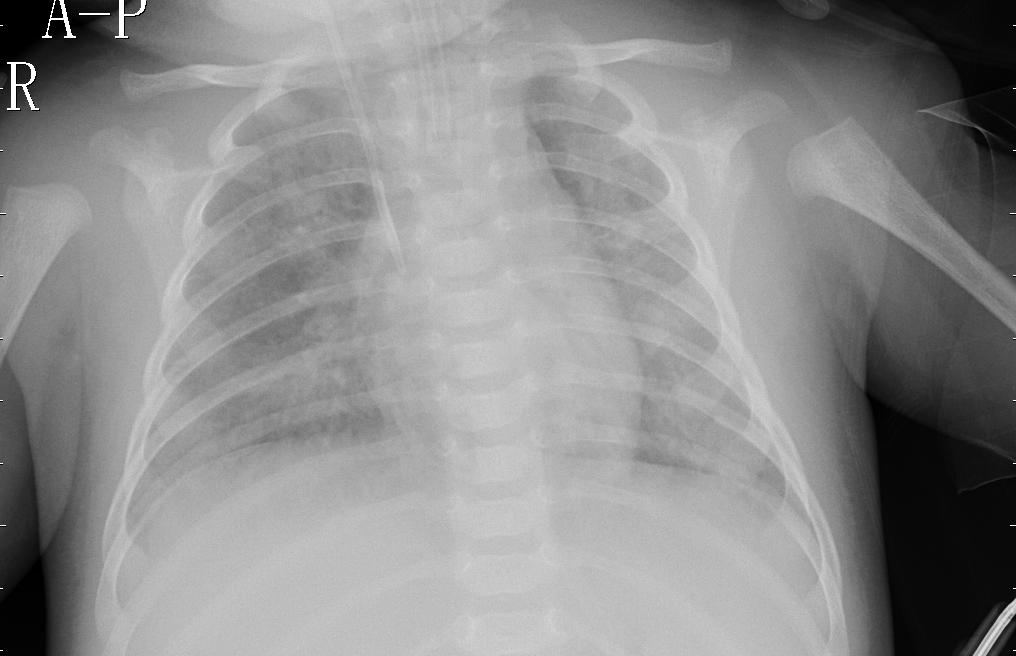

In [ ]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

test_img_path = glob.glob('drive/MyDrive/Pneumonia Classification/chest_xray/test/*/*.jpeg')
img = get_image(test_img_path[0])
print(test_img_path[0])
img

In [ ]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [ ]:
img_t = get_input_tensors(img) # transformed img
model.eval()
logits = model(img_t)

In [ ]:
idx2label = {
    0: 'NORMAL',
    1: 'PNEUMONIA'
}

In [ ]:
probs = F.softmax(logits, dim=1)
probs2 = probs.topk(2)
tuple((p,c, idx2label[c]) for p, c in zip(probs2[0][0].detach().numpy(), probs2[1][0].detach().numpy()))

((0.99321944, 1, 'PNEUMONIA'), (0.006780558, 0, 'NORMAL'))

# Using Lime

Lime produces the arrya of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output.

For PyTorch, first we need to define two seperate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [ ]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

1

## Creating Explanations

In [ ]:
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()
pneumonia_explanation = explainer.explain_instance(
    np.array(pill_transf(img)), 
    batch_predict, # classification function
    top_labels=2,
    hide_color=0,
    random_seed=0,
    distance_metric='l2',
    num_samples=100 # number of images that will be sent to classification function
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def plot_explanation(img, explanation, gt, num_features=5, classes=idx2label):
    pos_temp, pos_mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, negative_only=False, num_features=num_features, hide_rest=False)
    img_boundry1 = mark_boundaries(pos_temp/255.0, pos_mask, color=np.array([0, 255, 0])/255.)

    neg_temp, neg_mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, negative_only=True, num_features=num_features, hide_rest=False)
    img_boundry2 = mark_boundaries(neg_temp/255.0, neg_mask, color=np.array([255, 0, 0])/255.)

    # generating figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True, dpi=300)

    ax1.set_title('Original Image; Ground Truth: {}'.format(classes[gt]))
    ax1.imshow(img.resize((256, 256)))
    ax1.axis('off')

    ax2.set_title('Positive Explanation; Predicted: {}'.format(classes[explanation.top_labels[0]]))
    ax2.imshow(img_boundry1)
    ax2.axis('off')

    ax3.set_title('Negative Explanation; Predicted: {}'.format(classes[explanation.top_labels[0]]))
    ax3.imshow(img_boundry2)
    ax3.axis('off')

    plt.show()

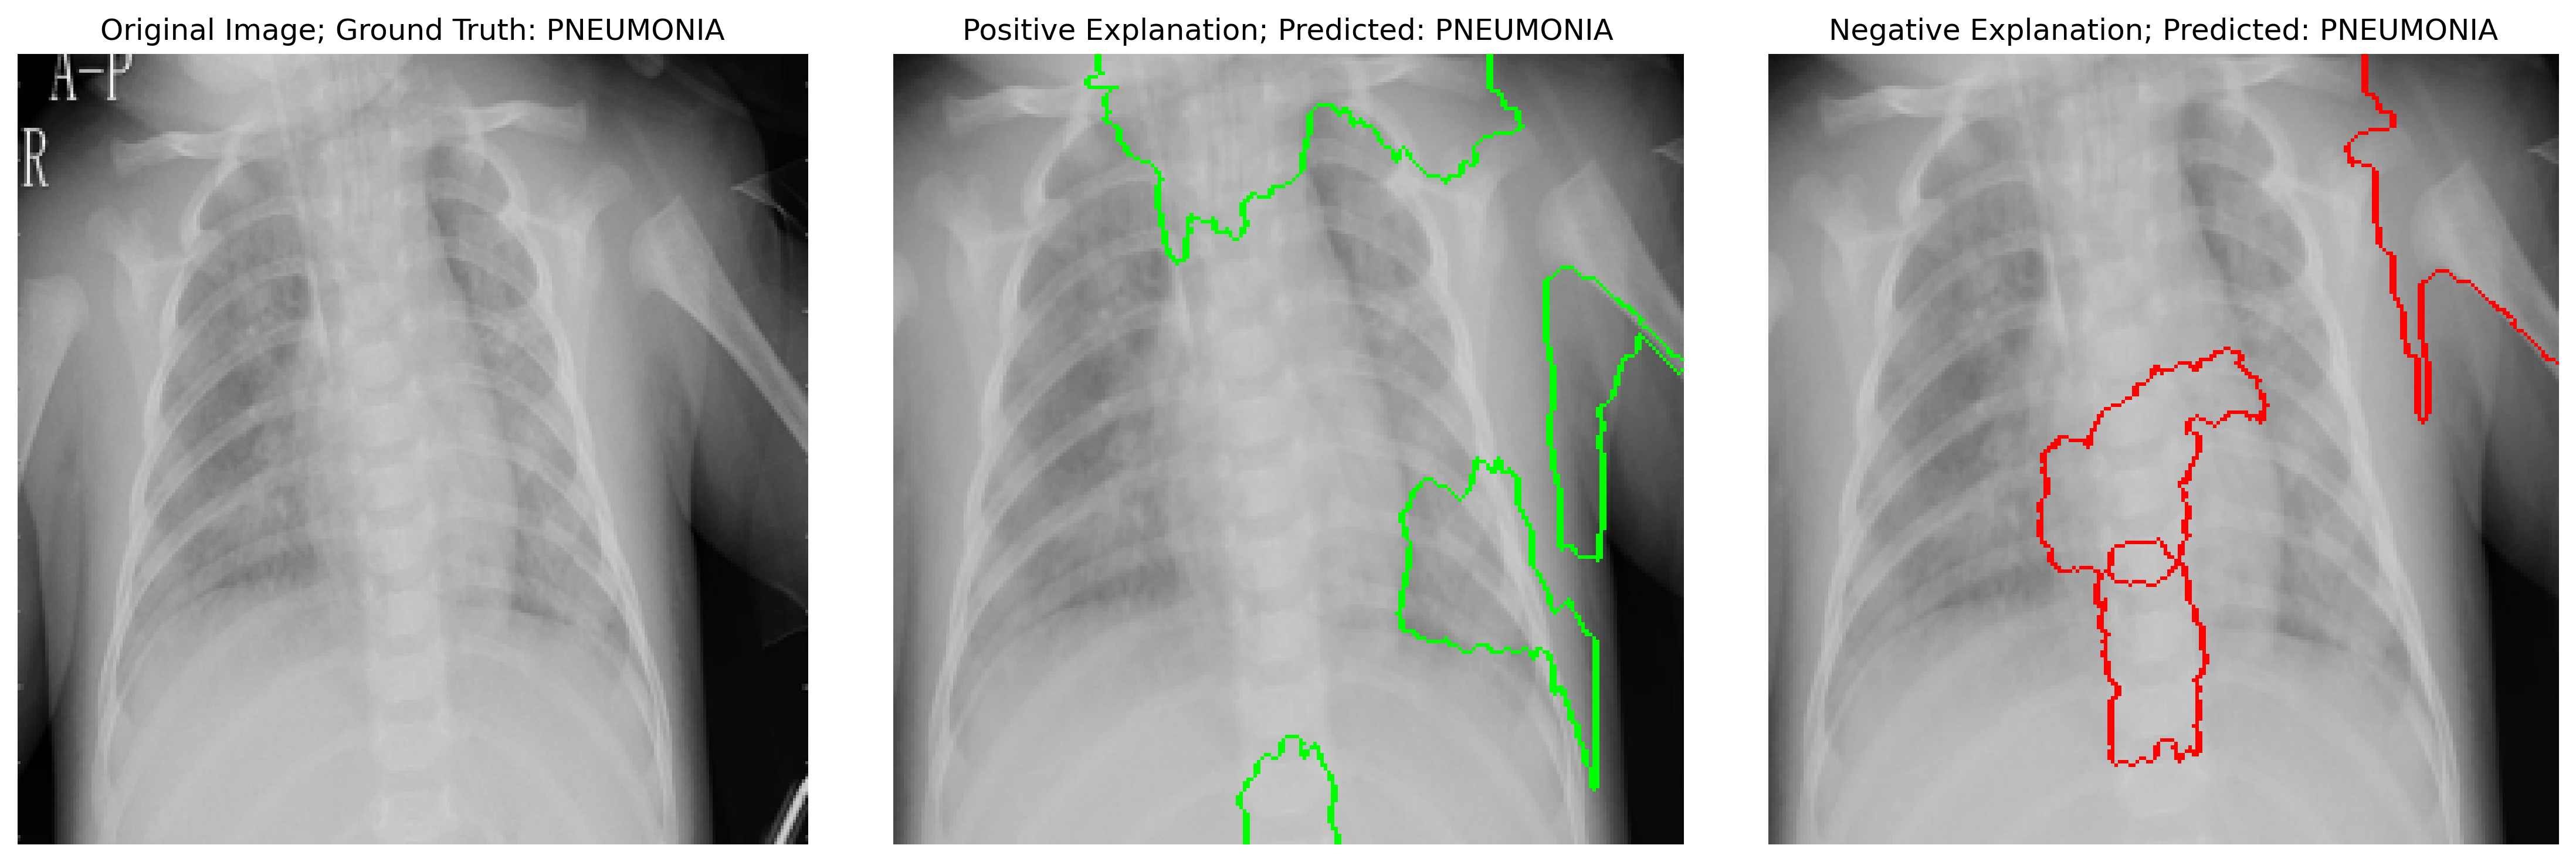

In [ ]:
plot_explanation(img, pneumonia_explanation, 1)

# Test Case (NORMAL)

In [ ]:
img2 = get_image(test_img_path[-2])
print(test_img_path[-2])

drive/MyDrive/Pneumonia Classification/chest_xray/test/NORMAL/NORMAL2-IM-1440-0001.jpeg


In [ ]:
explainer = lime_image.LimeImageExplainer()
normal_explanation = explainer.explain_instance(
    np.array(pill_transf(img2)), 
    batch_predict, # classification function
    top_labels=2,
    batch_size=4,
    random_seed=0,
    distance_metric='l2',
    num_samples=100 # number of images that will be sent to classification function
)
print(normal_explanation.top_labels[0])

  0%|          | 0/100 [00:00<?, ?it/s]

0


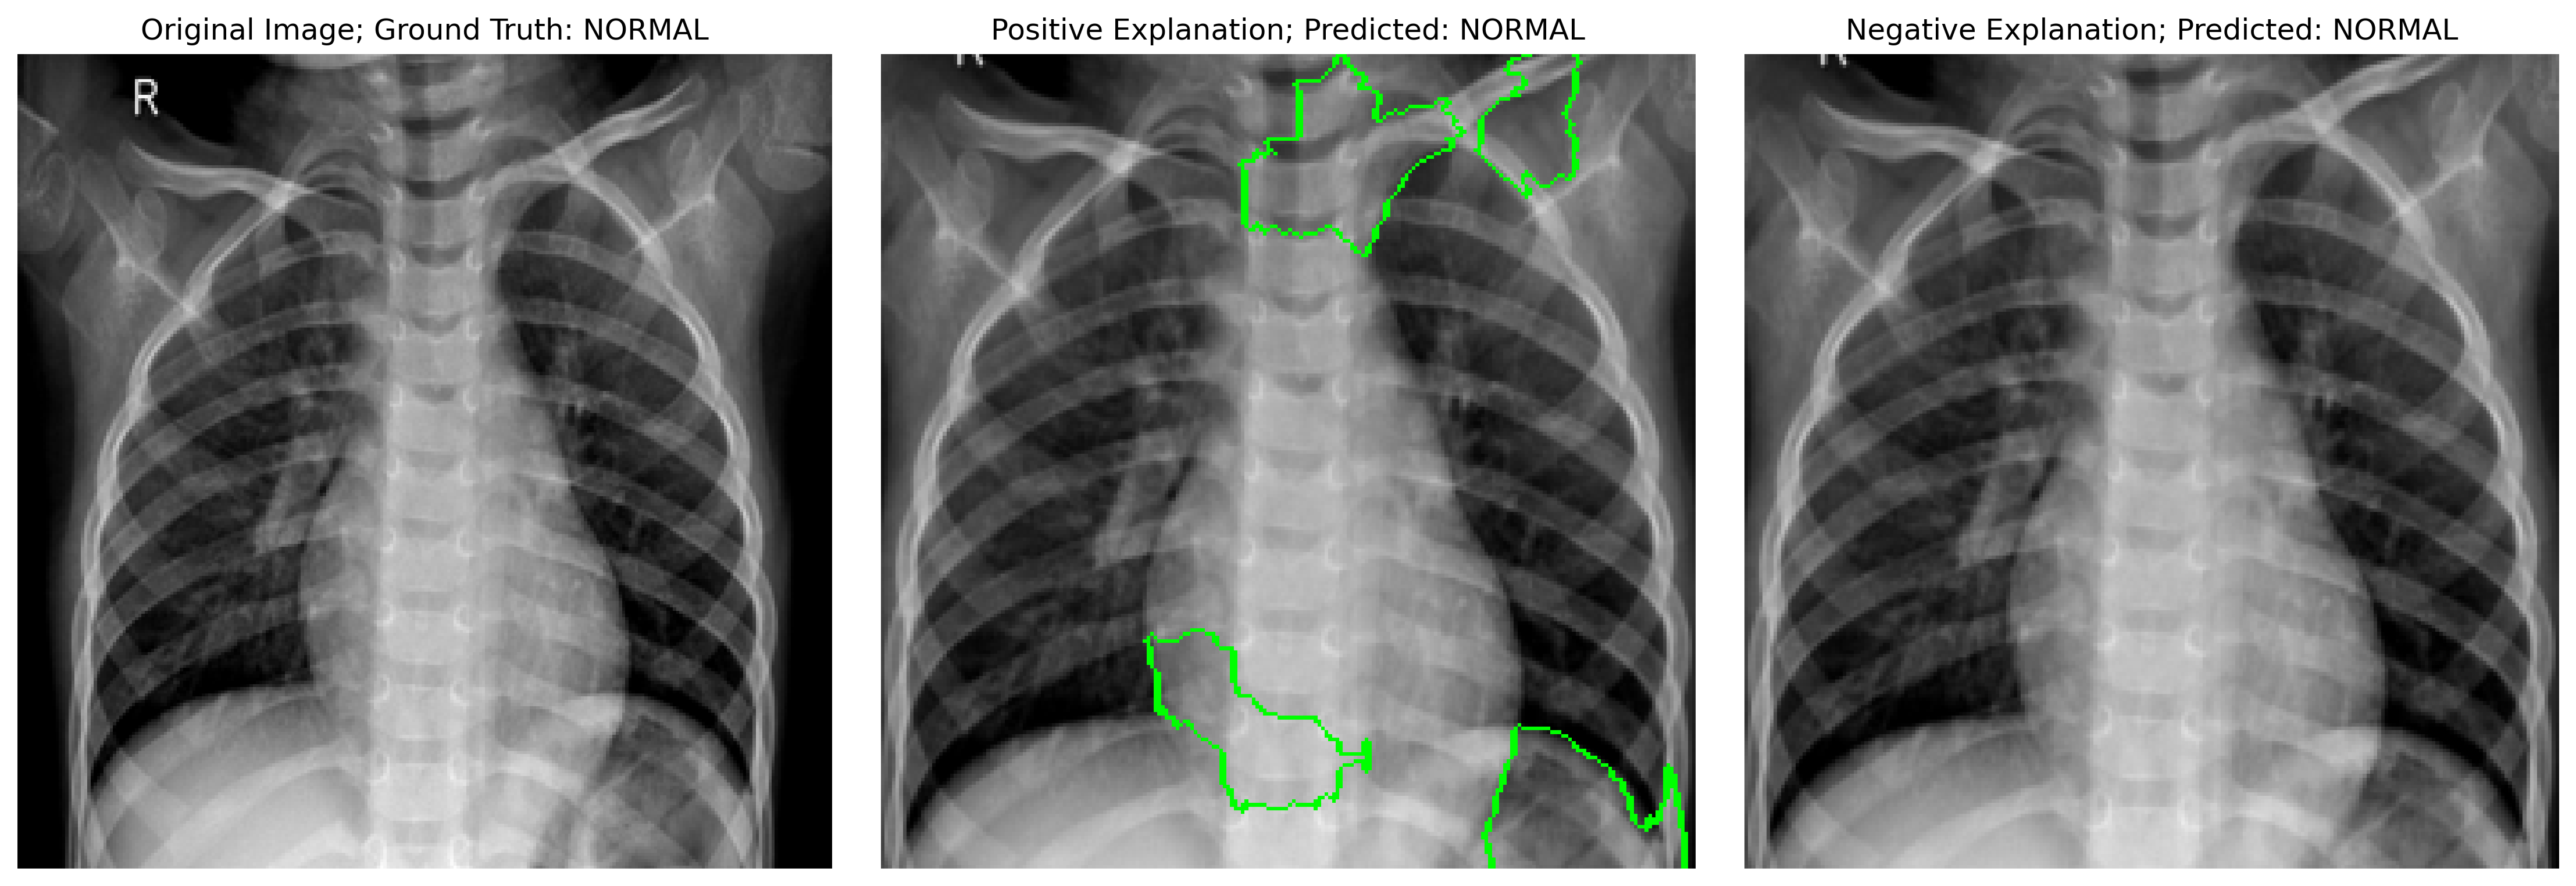

In [ ]:
plot_explanation(img2, normal_explanation, 0)